# Deep Learning (CS F425) Project Task 1
## Sanshrav Arora (2021A7PS2690P)

In [108]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from einops.layers.torch import Rearrange
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [135]:
# Define the LearnedAffineTransform, FullyConnectedLayer, ResidualMLPBlock, and ResidualMLPModel classes

# Learned affine transformation module: applies a learnable scaling (alpha) and shifting (beta)
class LearnedAffineTransform(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones([1, 1, dim]))  # Scaling factor
        self.beta = nn.Parameter(torch.zeros([1, 1, dim]))  # Shifting factor

    def forward(self, x):
        # Apply the learned affine transformation to the input
        return x * self.alpha + self.beta

# Fully connected feedforward layer with two linear layers, GELU activation, and dropout
class FullyConnectedLayer(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),  # First linear layer
            nn.GELU(),                   # GELU activation
            nn.Dropout(dropout),          # Dropout for regularization
            nn.Linear(hidden_dim, dim),   # Second linear layer
            nn.Dropout(dropout)           # Dropout for regularization
        )

    def forward(self, x):
        return self.net(x)

# Residual MLP block with affine transformations, token mixing, and feedforward network
class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, num_patches, mlp_dim, dropout=0.5, init_values=1e-4):
        super().__init__()
        self.pre_affine = LearnedAffineTransform(dim)  # Pre-affine transformation
        self.token_mix = nn.Sequential(
            Rearrange('b n d -> b d n'),  # Rearrange tensor for mixing tokens across patches
            nn.Linear(num_patches, num_patches),
            Rearrange('b d n -> b n d')
        )
        self.ff = FullyConnectedLayer(dim, mlp_dim, dropout)  # Feedforward layer
        self.post_affine = LearnedAffineTransform(dim)  # Post-affine transformation
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        x = self.pre_affine(x)
        x = x + self.gamma_1 * self.token_mix(x)  # Token mixing with residual connection
        x = self.post_affine(x)
        x = x + self.gamma_2 * self.ff(x)  # Feedforward with residual connection
        return x

# Residual MLP Model: combines patch embedding, positional encoding, and residual MLP blocks
class ResidualMLPModel(nn.Module):
    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, mlp_dim):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * in_channels

        # Patch embedding: converts image patches into a flat vector and projects it into the model's dimension
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(self.patch_dim, dim)
        )

        # Positional embeddings to retain spatial information for the patches
        self.positional_embeddings = nn.Parameter(torch.randn(1, self.num_patches, dim))

        # Stack of residual MLP blocks
        self.mlp_blocks = nn.ModuleList([
            ResidualMLPBlock(dim, self.num_patches, mlp_dim) for _ in range(depth)
        ])

        self.affine = LearnedAffineTransform(dim)  # Final affine transformation
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),         # Layer normalization before final classification
            nn.Linear(dim, num_classes)  # Linear layer for classification into `num_classes`
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        x += self.positional_embeddings  # Add positional embeddings for spatial information
        for mlp_block in self.mlp_blocks:
            x = mlp_block(x)
        x = self.affine(x)
        x = x.mean(dim=1)  # Global average pooling
        return self.mlp_head(x)  # Classification head

In [110]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0  # Reset counter if improvement
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [111]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.image_paths = [os.path.join(img_dir, img) for img in sorted(os.listdir(img_dir))]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")  # Convert image to RGB
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [112]:
# for Data Augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop((256, 256), scale=(0.8, 1.0)),  # Randomly resize and crop to 80-100% of original size
    transforms.RandomHorizontalFlip(p=0.5),   # Randomly flip horizontally with a 50% probability
    transforms.RandomRotation(20),            # Randomly rotate the image by ±20 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization with ImageNet statistics
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Labels
train_labels = pd.read_csv('train_labels.txt', header=None).values.flatten() - 1  # Adjust if labels start from 1
val_labels = pd.read_csv('val_labels.txt', header=None).values.flatten() - 1

# Dataset and DataLoader for training and validation
train_image_dir = 'train_data'
val_image_dir = 'val_data'

train_dataset = CustomImageDataset(train_image_dir, train_labels, transform=transform)
val_dataset = CustomImageDataset(val_image_dir, val_labels, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [113]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model initialization
model = ResidualMLPModel(in_channels=3, dim=256, num_classes=60, patch_size=16, image_size=256, depth=5, mlp_dim=512)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    early_stopping = EarlyStopping(patience=10, min_delta=0.001)  # Initialize with patience and delta

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')
        
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break  # Break out of the loop if stopping condition is met
            
    # Plot training & validation loss and accuracy
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    # Save the model
    torch.save(model.state_dict(), 'resmlp_model.pth')
    print("Model saved as 'resmlp_model.pth'")

# Validation function
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss = val_loss / total
    val_acc = correct / total

    return val_loss, val_acc

# Plotting function
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Loss plot
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/100], Train Loss: 3.5776, Train Accuracy: 0.0943, Val Loss: 3.1999, Val Accuracy: 0.1667
Epoch [2/100], Train Loss: 2.9892, Train Accuracy: 0.2163, Val Loss: 2.8699, Val Accuracy: 0.2467
Epoch [3/100], Train Loss: 2.7564, Train Accuracy: 0.2603, Val Loss: 2.7337, Val Accuracy: 0.2717
Epoch [4/100], Train Loss: 2.5845, Train Accuracy: 0.3080, Val Loss: 2.5492, Val Accuracy: 0.3200
Epoch [5/100], Train Loss: 2.4486, Train Accuracy: 0.3470, Val Loss: 2.4331, Val Accuracy: 0.3267
Epoch [6/100], Train Loss: 2.3298, Train Accuracy: 0.3633, Val Loss: 2.2812, Val Accuracy: 0.3683
Epoch [7/100], Train Loss: 2.2298, Train Accuracy: 0.3893, Val Loss: 2.2290, Val Accuracy: 0.3933
Epoch [8/100], Train Loss: 2.1435, Train Accuracy: 0.4157, Val Loss: 2.1621, Val Accuracy: 0.4450
Epoch [9/100], Train Loss: 2.0759, Train Accuracy: 0.4333, Val Loss: 2.1038, Val Accuracy: 0.4217
Epoch [10/100], Train Loss: 1.9623, Train Accuracy: 0.4687, Val Loss: 2.0519, Val Accuracy: 0.4500
Epoch [11/100], Tra

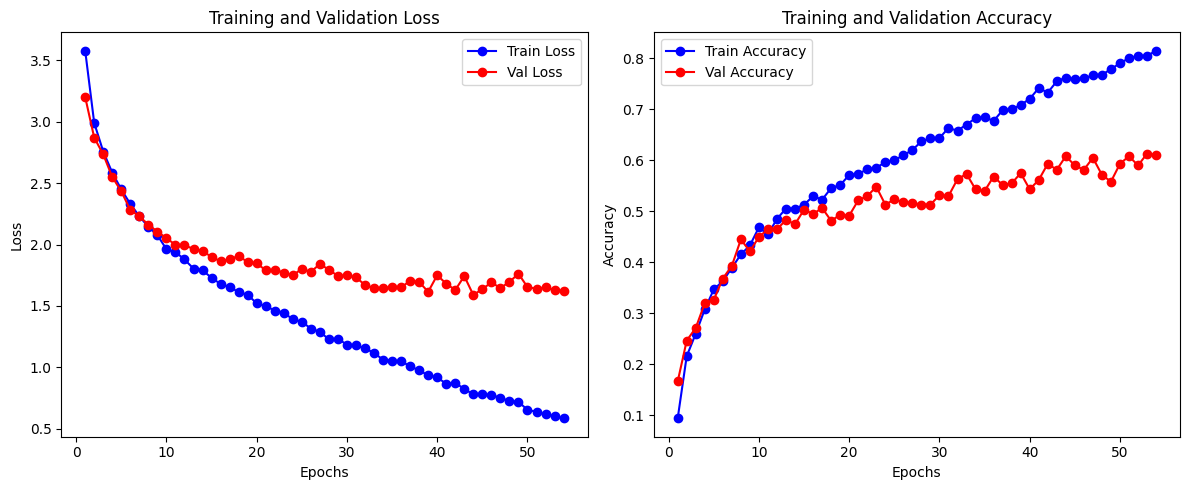

Model saved as 'resmlp_model.pth'


In [114]:
# Now, you can start training your model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=100)
#depth = 5, lr=0.001, weight_decay=0.0001 dropout = 0.5, batch size = 32, data augmentation without color jitter

# **TESTING CODE CELLS**

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd
from einops.layers.torch import Rearrange
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Defining the model the testing functions
class LearnedAffineTransform(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones([1, 1, dim]))
        self.beta = nn.Parameter(torch.zeros([1, 1, dim]))

    def forward(self, x):
        return x * self.alpha + self.beta

class FullyConnectedLayer(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class ResidualMLPBlock(nn.Module):
    def __init__(self, dim, num_patches, mlp_dim, dropout=0.5, init_values=1e-4):
        super().__init__()
        self.pre_affine = LearnedAffineTransform(dim)
        self.token_mix = nn.Sequential(
            Rearrange('b n d -> b d n'),
            nn.Linear(num_patches, num_patches),
            Rearrange('b d n -> b n d'),
        )
        self.ff = FullyConnectedLayer(dim, mlp_dim, dropout)
        self.post_affine = LearnedAffineTransform(dim)
        self.gamma_1 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)
        self.gamma_2 = nn.Parameter(init_values * torch.ones((dim)), requires_grad=True)

    def forward(self, x):
        x = self.pre_affine(x)
        x = x + self.gamma_1 * self.token_mix(x)
        x = self.post_affine(x)
        x = x + self.gamma_2 * self.ff(x)
        return x

class ResidualMLPModel(nn.Module):
    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, mlp_dim):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = patch_size * patch_size * in_channels

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.Linear(self.patch_dim, dim)
        )

        self.positional_embeddings = nn.Parameter(torch.randn(1, self.num_patches, dim))

        self.mlp_blocks = nn.ModuleList([
            ResidualMLPBlock(dim, self.num_patches, mlp_dim) for _ in range(depth)
        ])

        self.affine = LearnedAffineTransform(dim)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        x += self.positional_embeddings  
        for mlp_block in self.mlp_blocks:
            x = mlp_block(x)
        x = self.affine(x)
        x = x.mean(dim=1)
        return self.mlp_head(x)

model = ResidualMLPModel(in_channels=3, dim=256, num_classes=60, patch_size=16, image_size=256, depth=5, mlp_dim=512)
model.load_state_dict(torch.load('resmlp_model.pth'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
model.eval()

# Preprocessing function
def preprocess_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Load labels from file
def load_labels(labels_file):
    labels = []
    with open(labels_file, 'r') as f:
        for line in f:
            label = line.strip()
            if label:
                labels.append(int(label))  # Store each label as an integer
    return labels

# Function to classify a batch of test images and calculate accuracy
def classify_images(test_data_dir, labels_file):
    labels = load_labels(labels_file)
    image_files = sorted([img for img in os.listdir(test_data_dir) if img.endswith(('.png', '.jpg', '.jpeg'))])
    
    correct = 0
    total = 0
    
    # Ensure the number of images matches the number of labels
    if len(image_files) != len(labels):
        raise ValueError("The number of images and labels do not match.")

    # Iterate through the test images and their corresponding labels
    for idx, image_name in enumerate(image_files):
        image_path = os.path.join(test_data_dir, image_name)
        image = preprocess_image(image_path)
        image = image.to('cuda' if torch.cuda.is_available() else 'cpu')

        # Run the image through the model
        with torch.no_grad():
            output = model(image)
            predicted_class = output.argmax(dim=1).item()

        true_class = labels[idx]  # Get the corresponding label
        if predicted_class + 1 == true_class: # Adding 1 as labels are in range 1 to 60 and classes encoded from 0 to 59
            correct += 1
        total += 1

        print(f"Image: {image_name}, Predicted Class: {predicted_class + 1}, True Class: {true_class}")

    # Calculate and print accuracy
    accuracy = (correct / total) * 100 if total > 0 else 0
    print(f"Overall Accuracy: {accuracy:.2f}%")

C:\Users\Sanshrav Arora\AppData\Local\Temp\ipykernel_15508\403233801.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('resmlp_model.pth'

## Change Paths for Testing

In [5]:
test_data_dir = 'val_data' # '/path/to/test/dataset/' 
labels_file = 'val_labels.txt' # '/path/to/labels.txt' Labels from 1 to 60   

In [6]:
# Run classification on test images and calculate accuracy
classify_images(test_data_dir, labels_file)

Image: 10_image_04131.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04132.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04133.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04134.jpg, Predicted Class: 60, True Class: 1
Image: 10_image_04135.jpg, Predicted Class: 39, True Class: 1
Image: 10_image_04136.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04137.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04138.jpg, Predicted Class: 1, True Class: 1
Image: 10_image_04139.jpg, Predicted Class: 52, True Class: 1
Image: 10_image_04140.jpg, Predicted Class: 1, True Class: 1
Image: 11_image_03510.jpg, Predicted Class: 2, True Class: 2
Image: 11_image_03511.jpg, Predicted Class: 2, True Class: 2
Image: 11_image_03512.jpg, Predicted Class: 2, True Class: 2
Image: 11_image_03513.jpg, Predicted Class: 50, True Class: 2
Image: 11_image_03514.jpg, Predicted Class: 2, True Class: 2
Image: 11_image_03515.jpg, Predicted Class: 2, True Class: 2
Image: 11_image_0351